In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import Imputer
import DesicionTree as dt

In [2]:
def fit_preproc(x):
    colm_val_dict = {}
    for i in range(0,x.shape[1]):
        tmp = x[:, i]
        if type(tmp[0]) is str:
            count = 0
            value_dict = {}
            #составляем словарь
            for val in tmp:
                if not (val in value_dict.keys()):
                    if val == ' ?':
                        value_dict[val] = np.nan
                    else:
                        value_dict[val] = count
                        count+=1
            colm_val_dict[str(i)] = value_dict
    return colm_val_dict

In [3]:
def transform(x, tr_dict):
    for i in range(0,x.shape[1]):
        if str(i) in tr_dict:
            tmp = x[:, i]
            for j in range(len(tmp)):
                if tmp[j] in tr_dict[str(i)]:
                    x[j, i] = tr_dict[str(i)][tmp[j]]
                else:
                    x[j, i] = len(tr_dict[str(i)])/2
    return x

In [4]:
def sep_two_classes(Y, num_class):
    Y = Y.copy()
    for i in range(Y.shape[0]):
        if Y[i] == num_class:
            Y[i] = 1
        else:
            Y[i] = -1
    return Y

In [5]:
def Bagging_RSM(x, y, port):
    features =[]
    while not features:
        for i in range(x.shape[1]):
            checkf = np.random.randint(3)
            if checkf == 1:
                features.append(i)
    newx, newy = [], []
    
    for s in range(x.shape[0]):
        check = np.random.randint(port)
        if check == 1:
            xx = []
            for f in features:
                xx.append(x[s][f])
            newx.append(np.asarray(xx))
            newy.append(y[s])
    return np.asarray(newx), np.asarray(newy), features

In [6]:
def tree_weak_cls(X, tree):
    return dt.predict(tree[0], X[tree[1]])

In [7]:
def make_tree(X, Y, max_depth, min_size, port):
    X, Y, features = Bagging_RSM(X, Y, port)
    return dt.get_tree(X, Y, max_depth, min_size), features

In [8]:
def Q(X, Y, W, tree, features):
    Qsum = 0
    for i in range(X.shape[0]):
        b = dt.predict(tree, X[i, features])
        I = 1 if (Y[i]*b) < 0 else 0
        Qsum += W[i] * I
    return Qsum

In [9]:
def alpha(Q):
    return 0.5 * np.log((1-Q)/Q)

In [10]:
def fit(X, Y, num_weak_clf, T, port, max_depth_range=3, min_size_range=3):
    #1 инициализация весов объектов
    w = np.asarray([1/X.shape[0] for i in range(X.shape[0])])
    alphas = []
    bs = []
    #2 Для всех t=1,...,T, пока не выполнен критерий останова.
    while len(alphas) < num_weak_clf:     
        #2.1 Находим классификатор b_t: X->{-1,+1} который минимизирует взвешенную ошибку классификации;
        #b_t = argmin_b Q(b,W^l);
        Qs = []
        trees = []
        for i in range(T):
            tree, features = make_tree(X, Y, 1+np.random.randint(max_depth_range), 1+np.random.randint(min_size_range), port)
            trees.append((tree, features))
            Qs.append(Q(X, Y, w, tree, features))
            
        Qs = np.asarray(Qs)
        argmin = np.argmin(Qs)
        
        if Qs[argmin]> 0.5:
            pass
        else:
            bs.append(trees[argmin])
            #2.2 Пересчитываем кооэффициент взвешенного голосования для алгоритма классификации b_t:

            alpha_t = alpha(Qs[argmin])
            alphas.append(alpha_t)

            #2.3 Пересчет весов объектов: w_i = w_i*exp(-alpha_t*y_i*b_t(x_i)), i = 1,...,l
            for i in range(w.shape[0]):
                b = tree_weak_cls(X[i], trees[argmin])
                w[i] *= np.exp(-alpha_t*Y[i]*b)

            #2.4 Нормировка весов объектов:

            w0 = np.sum(w)
            for ww in w:
                ww/=w0
            
            print('--------------------------')
            print('Was made {num}th weak clfs:'.format(num=len(alphas)))
            dt.print_tree(trees[argmin][0])
            print('With features: {fs}'.format(fs=trees[argmin][1]))
            print('--------------------------\n\n')
    return np.asarray(alphas), np.asarray(bs)
        

In [11]:
def predict(X, alphas, tree):
    tmp_sum = 0
    for t in range(alphas.shape[0]):
        b = tree_weak_cls(X, tree=tree[t])
        tmp_sum += alphas[t] * b
    return np.sign(tmp_sum)

In [12]:
def accuracy(y_true, y_pred):
    counter = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            counter +=1
    return counter/len(y_true)

In [13]:
def plot_progress(X, Y, alphas, bs):
    progress = []
    for i in range(1, len(alphas)+1):
        predictions = []
        for x in X:
            predictions.append(predict(x, alphas[0:i], bs[0:i]))
        acc = accuracy(Y, predictions)
        print('accurecy({T} weak clfs): {acc}\n'.format(acc = acc,T=i))
        progress.append(acc)
    plt.plot(progress)
    #plt.yticks(np.arange(0, 1.0, 0.1))
    plt.show()

In [14]:
train = np.asarray(pd.read_csv('train2.csv'))
X , Y = train[:, :-1], train[:,-1]
p=np.random.permutation(X.shape[0])
x_train = X[p[0:int(len(X)*0.7)], :]
y_train = Y[p[0:int(len(Y)*0.7)]]
x_test = X[p[int(len(X)*0.7):], :]
y_test = Y[p[int(len(Y)*0.7):]]

prepr_dict = fit_preproc(x_train)
print('Dictionary:\n', prepr_dict)
x_train = transform(x_train, prepr_dict)
x_test = transform(x_test, prepr_dict)

imp_train = Imputer(missing_values=np.nan)
imp = imp_train.fit(x_train)
x_train = imp.transform(x_train)
x_test = imp.transform(x_test)

y_train = sep_two_classes(y_train, 1)
y_test = sep_two_classes(y_test, 1)

pd.set_option('display.height',1000)
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

df_train = pd.DataFrame([np.append(x_train[i], y_train[i]) for i in range(x_train.shape[0])], columns = [str(i) for i in range(x_train.shape[1]+1)])
print('\nTrain data:\n', df_train)

df_test = pd.DataFrame([np.append(x_test[i], y_test[i]) for i in range(x_test.shape[0])], columns = [str(i) for i in range(x_test.shape[1]+1)])
print('\nTest data:\n', df_test)

#x_train = (x_train - np.mean(x_train, axis = 0)) / np.var(x_train, axis = 0)
#x_test = (x_test - np.mean(x_test, axis = 0)) / np.var(x_test, axis = 0)



Dictionary:
 {'1': {' Private': 0, ' Self-emp-not-inc': 1, ' ?': nan, ' Local-gov': 2, ' Self-emp-inc': 3, ' State-gov': 4, ' Federal-gov': 5, ' Without-pay': 6, ' Never-worked': 7}, '3': {' Some-college': 0, ' Prof-school': 1, ' HS-grad': 2, ' 7th-8th': 3, ' 12th': 4, ' Assoc-acdm': 5, ' Bachelors': 6, ' 11th': 7, ' 9th': 8, ' Assoc-voc': 9, ' 10th': 10, ' Masters': 11, ' Doctorate': 12, ' 5th-6th': 13, ' 1st-4th': 14, ' Preschool': 15}, '5': {' Never-married': 0, ' Married-civ-spouse': 1, ' Widowed': 2, ' Separated': 3, ' Divorced': 4, ' Married-spouse-absent': 5, ' Married-AF-spouse': 6}, '6': {' Sales': 0, ' Prof-specialty': 1, ' Adm-clerical': 2, ' Exec-managerial': 3, ' ?': nan, ' Craft-repair': 4, ' Farming-fishing': 5, ' Machine-op-inspct': 6, ' Tech-support': 7, ' Handlers-cleaners': 8, ' Transport-moving': 9, ' Other-service': 10, ' Protective-serv': 11, ' Priv-house-serv': 12, ' Armed-Forces': 13}, '7': {' Own-child': 0, ' Husband': 1, ' Other-relative': 2, ' Not-in-family':

In [22]:
num_wclfs = 40
start_time = time.time()
alphas, bs = fit(X=x_train, Y=y_train, num_weak_clf=num_wclfs, T=10, port=100, max_depth_range=10, min_size_range=10)

--------------------------
Was made 1th weak clfs:
[X7 < 5178.000]
 [X4 < 4.246]
  [X5 < 2.000]
   [X1 < 32.000]
    [X3 < 6.000]
     [X1 < 29.000]
      [X1 < 22.000]
       [X1 < 18.000]
        [-1.0]
        [X1 < 18.000]
         [-1.0]
         [-1.0]
       [X1 < 22.000]
        [-1.0]
        [-1.0]
      [-1.0]
     [1.0]
    [X4 < 3.000]
     [X1 < 47.000]
      [X1 < 33.000]
       [1.0]
       [X2 < 9.000]
        [X1 < 37.000]
         [-1.0]
         [1.0]
        [1.0]
      [X1 < 67.000]
       [X1 < 60.000]
        [X1 < 54.000]
         [X1 < 51.000]
          [1.0]
          [1.0]
         [1.0]
        [1.0]
       [1.0]
     [X1 < 64.000]
      [X8 < 68.000]
       [X8 < 50.000]
        [X1 < 42.000]
         [-1.0]
         [X1 < 49.000]
          [1.0]
          [-1.0]
        [1.0]
       [-1.0]
      [-1.0]
   [X4 < 2.000]
    [X2 < 2.000]
     [1.0]
     [X8 < 50.000]
      [X1 < 35.000]
       [-1.0]
       [X1 < 35.000]
        [-1.0]
        [-1.0]
      [

--------------------------
Was made 8th weak clfs:
[X6 < 3.000]
 [X6 < 1.000]
  [-1.0]
  [1.0]
 [X4 < 13.000]
  [-1.0]
  [-1.0]
With features: [0, 1, 2, 4, 5, 7, 8]
--------------------------


--------------------------
Was made 9th weak clfs:
[X2 < 45.000]
 [-1.0]
 [1.0]
With features: [1, 12, 13]
--------------------------


--------------------------
Was made 10th weak clfs:
[X2 < 1.000]
 [X1 < 31.000]
  [X1 < 21.000]
   [X1 < 19.000]
    [-1.0]
    [-1.0]
   [X1 < 21.000]
    [-1.0]
    [-1.0]
  [X1 < 35.000]
   [-1.0]
   [X1 < 36.000]
    [-1.0]
    [X1 < 36.000]
     [-1.0]
     [-1.0]
 [X2 < 2.000]
  [X5 < 5178.000]
   [X1 < 33.000]
    [X1 < 29.000]
     [-1.0]
     [-1.0]
    [X1 < 63.000]
     [1.0]
     [-1.0]
   [1.0]
  [X2 < 6.000]
   [X1 < 64.000]
    [X1 < 32.000]
     [-1.0]
     [-1.0]
    [1.0]
   [1.0]
With features: [0, 5, 8, 9, 10, 13]
--------------------------


--------------------------
Was made 11th weak clfs:
[X1 < 38.000]
 [X3 < 7688.000]
  [X4 < 42.000]
  

--------------------------
Was made 16th weak clfs:
[X3 < 13.000]
 [X1 < 31.000]
  [X1 < 28.000]
   [X1 < 22.000]
    [X1 < 20.000]
     [X1 < 18.000]
      [X1 < 17.000]
       [-1.0]
       [-1.0]
      [X1 < 18.000]
       [-1.0]
       [-1.0]
     [X1 < 20.000]
      [-1.0]
      [-1.0]
    [X1 < 22.000]
     [-1.0]
     [-1.0]
   [X1 < 28.000]
    [-1.0]
    [-1.0]
  [X3 < 10.000]
   [X3 < 9.000]
    [X1 < 39.000]
     [-1.0]
     [X1 < 39.000]
      [-1.0]
      [-1.0]
    [X4 < 2.000]
     [X4 < 1.000]
      [X1 < 32.000]
       [-1.0]
       [-1.0]
      [X2 < 0.650]
       [X1 < 48.000]
        [X1 < 37.000]
         [1.0]
         [X1 < 39.000]
          [-1.0]
          [-1.0]
        [1.0]
       [X2 < 4.000]
        [X1 < 70.000]
         [-1.0]
         [-1.0]
        [1.0]
     [X1 < 57.000]
      [X1 < 35.000]
       [-1.0]
       [X1 < 35.000]
        [-1.0]
        [-1.0]
      [-1.0]
   [X5 < 45.000]
    [X4 < 2.000]
     [X4 < 1.000]
      [-1.0]
      [X1 < 37.000]

--------------------------
Was made 25th weak clfs:
[X4 < 4.000]
 [X4 < 3.000]
  [X3 < 6.000]
   [X2 < 337587.000]
    [X2 < 212506.000]
     [X2 < 185556.000]
      [X2 < 135436.000]
       [X2 < 99682.000]
        [X1 < 0.000]
         [-1.0]
         [-1.0]
        [X2 < 107125.000]
         [1.0]
         [-1.0]
       [X2 < 169527.000]
        [X1 < 3.000]
         [-1.0]
         [1.0]
        [X1 < 4.000]
         [-1.0]
         [-1.0]
      [X2 < 201112.000]
       [X1 < 0.000]
        [1.0]
        [1.0]
       [X2 < 203653.000]
        [-1.0]
        [1.0]
     [X1 < 0.000]
      [-1.0]
      [-1.0]
    [X2 < 404453.000]
     [1.0]
     [-1.0]
   [X2 < 238257.000]
    [X2 < 67218.000]
     [-1.0]
     [X2 < 125461.000]
      [X1 < 1.000]
       [X1 < 0.000]
        [1.0]
        [1.0]
       [1.0]
      [X2 < 175534.000]
       [X1 < 4.000]
        [X1 < 2.000]
         [-1.0]
         [-1.0]
        [1.0]
       [X4 < 2.000]
        [X4 < 1.000]
         [1.0]
         [1.0

--------------------------
Was made 31th weak clfs:
[X1 < 31.000]
 [X4 < 50.000]
  [X1 < 28.000]
   [X1 < 22.000]
    [X1 < 20.000]
     [-1.0]
     [-1.0]
    [X1 < 22.000]
     [-1.0]
     [-1.0]
   [X1 < 28.000]
    [-1.0]
    [-1.0]
  [X3 < 1.000]
   [X4 < 60.000]
    [X4 < 55.000]
     [-1.0]
     [1.0]
    [X1 < 23.000]
     [-1.0]
     [-1.0]
   [1.0]
 [X4 < 40.000]
  [X1 < 54.000]
   [X1 < 34.000]
    [-1.0]
    [X1 < 34.000]
     [-1.0]
     [-1.0]
   [X4 < 30.000]
    [X1 < 67.000]
     [-1.0]
     [-1.0]
    [1.0]
  [X2 < 5.000]
   [X2 < 0.650]
    [X1 < 35.000]
     [-1.0]
     [1.0]
    [X4 < 44.000]
     [-1.0]
     [-1.0]
   [1.0]
With features: [0, 1, 8, 12]
--------------------------


--------------------------
Was made 32th weak clfs:
[X1 < 32.000]
 [X1 < 27.000]
  [X1 < 23.000]
   [X1 < 20.000]
    [X1 < 18.000]
     [-1.0]
     [X1 < 18.000]
      [-1.0]
      [-1.0]
    [X1 < 20.000]
     [-1.0]
     [-1.0]
   [X1 < 24.000]
    [X3 < 6.000]
     [X1 < 23.000]
    

--------------------------
Was made 38th weak clfs:
[X1 < 42.000]
 [-1.0]
 [1.0]
With features: [0, 2, 4, 5, 6, 8, 11]
--------------------------


--------------------------
Was made 39th weak clfs:
[X1 < 28.000]
 [X2 < 36877.000]
  [1.0]
  [X1 < 17.000]
   [-1.0]
   [-1.0]
 [X3 < 11.000]
  [X3 < 8.000]
   [X1 < 64.000]
    [X1 < 39.000]
     [-1.0]
     [X1 < 39.000]
      [-1.0]
      [-1.0]
    [-1.0]
   [X1 < 53.000]
    [X2 < 353824.000]
     [X2 < 170562.000]
      [X2 < 155489.000]
       [X2 < 121966.000]
        [X1 < 43.000]
         [X1 < 36.000]
          [-1.0]
          [-1.0]
         [1.0]
        [-1.0]
       [1.0]
      [X1 < 31.000]
       [1.0]
       [X4 < 2.000]
        [-1.0]
        [X1 < 40.000]
         [-1.0]
         [X1 < 40.000]
          [-1.0]
          [-1.0]
     [1.0]
    [X1 < 59.000]
     [1.0]
     [X2 < 376973.000]
      [X4 < 10.000]
       [X1 < 62.000]
        [-1.0]
        [-1.0]
       [1.0]
      [1.0]
  [X1 < 57.000]
   [X4 < 1.000]
    

--- 2808.773275613785 seconds ---

accurecy(1 weak clfs): 0.8066332275565564

accurecy(2 weak clfs): 0.8066332275565564

accurecy(3 weak clfs): 0.8353976865595251

accurecy(4 weak clfs): 0.8353976865595251

accurecy(5 weak clfs): 0.8357047804278841

accurecy(6 weak clfs): 0.8315078308936431

accurecy(7 weak clfs): 0.8342716757088751

accurecy(8 weak clfs): 0.8301770907974204

accurecy(9 weak clfs): 0.8331456648582249

accurecy(10 weak clfs): 0.8303818200429931

accurecy(11 weak clfs): 0.8301770907974204

accurecy(12 weak clfs): 0.8320196540075749

accurecy(13 weak clfs): 0.8321220186303614

accurecy(14 weak clfs): 0.8333503941037977

accurecy(15 weak clfs): 0.8349882280683796

accurecy(16 weak clfs): 0.8351929573139523

accurecy(17 weak clfs): 0.8349882280683796

accurecy(18 weak clfs): 0.8352953219367386

accurecy(19 weak clfs): 0.8336574879721568

accurecy(20 weak clfs): 0.8333503941037977

accurecy(21 weak clfs): 0.8356024158050978

accurecy(22 weak clfs): 0.8359095096734569

accure

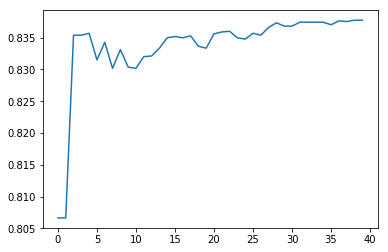

In [23]:
print("--- %s seconds ---\n" % (time.time() - start_time))
plot_progress(x_test, y_test, alphas, bs)

In [25]:
import pickle
with open('meta.pkl', 'wb') as f:
    pickle.dump((alphas, bs), f, pickle.HIGHEST_PROTOCOL)